# Backward stepwise linear regression


In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Definition of the functions:

In [2]:
def bw_step_model_reg(X,y):
    # This is a manual automation in which each iteration trains a linear regression model,
    # then those variables whose p-value>0.05 are eliminated, the loop ends when there are no variables 
    # with p-value>0.05 left until then it returns the df X with the significant variables and the model  as "model".
    
    import statsmodels.api as sm
    from sklearn.metrics import r2_score

    model= sm.OLS(y, X).fit()
    y_pred=model.predict(X)
    
    #R2=r2_score(y, y_pred)
    r2_model=[model.rsquared.round(4)]
    #r2_calc=[R2.round(4)]
    r2_ajust_model=[model.rsquared_adj.round(4)]
    #r2_ajust_calc=[(1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)).round(4)]
  
    aic=[model.aic.round(2)]
    bic=[model.bic.round(2)]
    variables=[X.shape[1]]
    var_deleted=[]
    
    while any(model.pvalues>0.05):
        #print(model.pvalues)
        var_max_ant=model.pvalues.reset_index().loc[np.where(model.pvalues==model.pvalues.max())[0][0],'index']
        nuevas_vars=list(set(list(X.columns))-set([var_max_ant]))
        X=X[nuevas_vars]
        model= sm.OLS(y, X).fit()
        y_pred=model.predict(X)
        
        #R2=r2_score(y, y_pred)
        r2_model.append(model.rsquared.round(4))
        #r2_calc.append(R2.round(4))
        r2_ajust_model.append(model.rsquared_adj.round(4))
        #r2_ajust_calc.append((1 - (1-R2)*(len(y)-1)/(len(y)-X.shape[1]-1)).round(4))
        aic.append(model.aic.round(2))
        bic.append(model.bic.round(2))
        variables.append(X.shape[1])
        var_deleted.append(var_max_ant)
    
    var_deleted.append("-") 
    performance_summary={"no_variables": variables,
                         "Deleted_Variables": var_deleted,
                         "r2_model": r2_model,
                         #"r2_calc": r2_calc,
                         "r2_ajust_model": r2_ajust_model,
                         #"r2_ajust_calc": r2_ajust_calc,
                         "aic": aic,
                         "bic": bic}
   
    performance_summary=pd.DataFrame.from_dict(performance_summary)
     
    return (X, model, performance_summary)

In [3]:
def funplot(performance_summary):
    from matplotlib.ticker import MaxNLocator

    xplot=performance_summary.no_variables

    fig = plt.figure(figsize=(6, 6))

    gs = fig.add_gridspec(3, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    fig.suptitle('Backward Stepwise Regression model Performance')
    axs[0].plot(xplot, performance_summary.r2_model)
    axs[0].set_ylabel('R2')
    axs[1].plot(xplot, performance_summary.r2_ajust_model, 'tab:orange')
    axs[1].set_ylabel('R2 adj')
    axs[2].plot(xplot, performance_summary.bic, 'tab:red', label='BIC')
    axs[2].plot(xplot, performance_summary.aic, 'tab:blue', label='AIC')
    axs[2].legend(loc="upper right")
    axs[2].set_ylabel('AIC y BIC')
    axs[0].invert_xaxis()
    axs[1].invert_xaxis()
    #axs[2].invert_xaxis()

    # Hide x labels and tick labels for all but bottom plot.
    for ax in axs:
        ax.label_outer() 
        ax.invert_xaxis()
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.grid()

## Load variables

In [4]:
# Explanatory data path
path=r"..\vars.xlsx"
path=path.replace(os.sep, "/")

# Load explanatory variables
explanatory=pd.read_excel(path,
                          sheet_name="Vars")

# Round
var_exp=['poblacion', 'estudiantes',
       'ss_trabajo', 'ss_residencia', 'parque_vehicular', 'plazas_hoteleras',
       'renta_bruta', 'superficie_vivienda_total', 'superficie_industrial',
       'superficie_oficinas', 'superficie_comercial', 'superficie_deportiva',
       'superficie_hosteleria_ocio', 'superficie_cultural',
       'superficie_espectaculos', 'superficie_religion',
       'superficie_construida_agricola']
explanatory[var_exp]=explanatory[var_exp].round(0)
#Ajustes de preparación de datos
#explanatory.index=explanatory.cumun
explanatory=explanatory.drop(['municipio', 'cumun', 'macrozona'],axis=1)
explanatory.head(3)

,poblacion,estudiantes,ss_trabajo,ss_residencia,parque_vehicular,plazas_hoteleras,renta_bruta,superficie_vivienda_total,superficie_industrial,superficie_oficinas,superficie_comercial,superficie_deportiva,superficie_hosteleria_ocio,superficie_cultural,superficie_espectaculos,superficie_religion,superficie_construida_agricola
0,25501,4779,7296.0,10160.0,20438,194,17825.0,1316230,75031,24075,98200,18318,25948,35614,271,3926,66572
1,3733,706,1227.0,1437.0,3536,0,18408.0,249462,24968,4006,13013,7339,8210,8742,0,983,20858
2,200753,62263,90744.0,73036.0,142206,3932,25682.0,9605737,311230,327128,922770,747067,256401,488633,20758,52288,182376


In [5]:
# Dependent data path
dependents=pd.read_excel(path,
                          sheet_name="y")
#Ajustes de preparación de datos
#dependents.index=dependents.cumun

var_inde=['HBWS Producción']
 
dependents=dependents[var_inde]
dependents.rename(columns={"HBWS Producción":"y"}, inplace=True)
dependents.head(3)

,y
0,13856.983424
1,2641.732971
2,123427.227013


## Run model

In [6]:
signfificative_explanatory_vars, model, performance_summary = bw_step_model_reg(explanatory, dependents)

In [7]:
#Explanatory variables
explanatory.columns

Index(['poblacion', 'estudiantes', 'ss_trabajo', 'ss_residencia',
       'parque_vehicular', 'plazas_hoteleras', 'renta_bruta',
       'superficie_vivienda_total', 'superficie_industrial',
       'superficie_oficinas', 'superficie_comercial', 'superficie_deportiva',
       'superficie_hosteleria_ocio', 'superficie_cultural',
       'superficie_espectaculos', 'superficie_religion',
       'superficie_construida_agricola'],
      dtype='object')

In [8]:
#Significative variables
signfificative_explanatory_vars.columns

Index(['superficie_hosteleria_ocio', 'ss_trabajo', 'superficie_comercial',
       'superficie_deportiva', 'parque_vehicular', 'ss_residencia',
       'poblacion', 'plazas_hoteleras', 'superficie_cultural'],
      dtype='object')

In [9]:
performance_summary

,no_variables,Deleted_Variables,r2_model,r2_ajust_model,aic,bic
0,17,estudiantes,1.0000,0.9998,330.92,349.47
1,16,renta_bruta,1.0000,0.9999,329.19,346.65
2,15,superficie_vivienda_total,1.0000,0.9999,327.52,343.89
3,14,superficie_industrial,1.0000,0.9999,331.21,346.48
4,13,superficie_religion,0.9999,0.9999,332.09,346.27
5,12,superficie_espectaculos,0.9999,0.9999,332.82,345.91
6,11,superficie_construida_agricola,0.9999,0.9999,335.82,347.82
7,10,superficie_oficinas,0.9999,0.9998,337.34,348.25
8,9,-,0.9999,0.9998,339.97,349.79


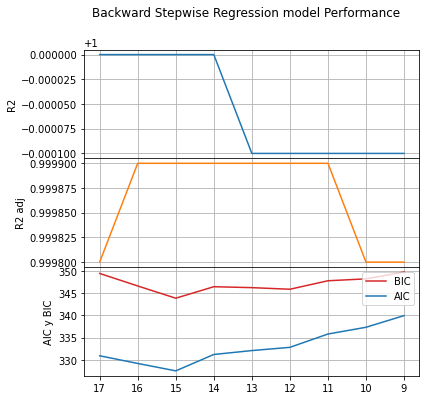

In [10]:
# Performance plots
funplot(performance_summary)

Hope this can help you
**Follow me on
[LinkedIn](https://www.linkedin.com/in/luisenriquepalma/)**